# DATSCI W261 ASSIGNMENT #3
[Natarajan Krishnaswami](mailto:natarajan@krishnaswami.org)  
Version 2016-01-27 (FINAL)  
2016-01-30

# SPECIAL INSTURCTIONS
HW3 is a group exercise. Your team assignments for completing HW3 (and future homeworks) are located at:

https://docs.google.com/spreadsheets/d/1ncFQl5Tovn-16slD8mYjP_nzMTPSfiGeLLzW8v_sMjg/edit?usp=sharing

See column Team assignment for Homeworks in tab "Teams for HW Assignments"

Note: please submit one homework submission per group.

# Week 3 ASSIGNMENTS
---
## HW3.0.
1. What is a merge sort? Where is it used in Hadoop?
1. How is  a combiner function in the context of Hadoop? 
1. Give an example where it can be used and justify why it should be used in the context of this problem.
1. What is the Hadoop shuffle?

1. **Mergesort** is a divide-and-conquer-friendly sorting algorithm based on the observations that
  * single-item lists are sorted
  * sorted lists may be merged with $O(n)$ comparisons in the lengths of the lists.
  Thus, the sort consists of merging the sorted left and right halves of a list.  If the halves are a single item, they are returned, otherwise their left and right halves are sorted, merged and returned.  
  In Hadoop,
    * Mapper output is partitioned and sorted in RAM before being fed to the combiner in a circular buffer.
    * Once the buffer is (almost) full, it is spilled to disk. These spill files are then also partitioned, sorted within each partition, and combined.
    * Reducers can receive data from many mappers; these are merged and combined to produce each reducer's input.
2. A combiner function combines mapper output to reduce the volume of data transfer to the reducers.  An algorithm should be designed to produce the same output regardless of whether they are not invoked at all or invoked many times.
3. In the standard wordcount example, if a word is repeated in a single mapper's input, it will be emitted many times with a count of 1.  With a combiner, these will be consolidated into a single key/value before being written to spill or partition files, and before being sent to a reducer.  This can save substantial network and disk traffic.
4. The hadoop shuffle is everything that happens between the mappers producing output and the reducers receiving input.  That is, the partitioning/sorting/combining on the mapper side, the transmission of partitions to their reducers, and the merging/combining of mappers' partition data to produce reducer input.

---
## HW3.1
### Use Counters to do EDA (exploratory data analysis and to monitor progress)
Counters are lightweight objects in Hadoop that allow you to keep track of system progress in both the map and reduce stages of processing. By default, Hadoop defines a number of standard counters in "groups"; these show up in the jobtracker webapp, giving you information such as "Map input records", "Map output records", etc. 

While processing information/data using MapReduce job, it is a challenge to monitor the progress of parallel threads running across nodes of distributed clusters. Moreover, it is also complicated to distinguish between the data that has been processed and the data which is yet to be processed. The MapReduce Framework offers a provision of user-defined Counters, which can be effectively utilized to monitor the progress of data across nodes of distributed clusters.

Use the Consumer Complaints  Dataset provide here to complete this question:

 * https://www.dropbox.com/s/vbalm3yva2rr86m/Consumer_Complaints.csv?dl=0

The consumer complaints dataset consists of diverse consumer complaints, which have been reported across the United States regarding various types of loans. The dataset consists of records of the form:

```
Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Submitted via,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
```

Here’s is the first few lines of the  of the Consumer Complaints  Dataset:

```
Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Submitted via,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
1114245,Debt collection,Medical,Disclosure verification of debt,Not given enough info to verify debt,FL,32219,Web,11/13/2014,11/13/2014,"Choice Recovery, Inc.",Closed with explanation,Yes,
1114488,Debt collection,Medical,Disclosure verification of debt,Right to dispute notice not received,TX,75006,Web,11/13/2014,11/13/2014,"Expert Global Solutions, Inc.",In progress,Yes,
1114255,Bank account or service,Checking account,Deposits and withdrawals,,NY,11102,Web,11/13/2014,11/13/2014,"FNIS (Fidelity National Information Services, Inc.)",In progress,Yes,
1115106,Debt collection,"Other (phone, health club, etc.)",Communication tactics,Frequent or repeated calls,GA,31721,Web,11/13/2014,11/13/2014,"Expert Global Solutions, Inc.",In progress,Yes,
```

### User-defined Counters

Now, let’s use Hadoop Counters to identify the number of complaints pertaining to debt collection, mortgage and other categories (all other categories get lumped into this one) in the consumer complaints dataset. Basically produce the distribution of the Product column in this dataset using counters (limited to 3 counters here).

Hadoop offers Job Tracker, an UI tool to determine the status and statistics of all jobs. Using the job tracker UI, developers can view the Counters that have been created. Screenshot your  job tracker UI as your job completes and include it here. Make sure that your user defined counters are visible. 


In [1]:
# HW 3.1: fetch data
!wget -O Consumer_Complaints.csv https://www.dropbox.com/s/vbalm3yva2rr86m/Consumer_Complaints.csv?dl=1

--2016-01-31 21:47:29--  https://www.dropbox.com/s/vbalm3yva2rr86m/Consumer_Complaints.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 108.160.172.206, 108.160.172.238
Connecting to www.dropbox.com (www.dropbox.com)|108.160.172.206|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://dl.dropboxusercontent.com/content_link/IDwkBqKwOZVhCAFZzqS0P9u2XOYN0Z3KP7CrYWLsseOFaiYICK09NmQ0Sst7Nkoq/file?dl=1 [following]
--2016-01-31 21:47:29--  https://dl.dropboxusercontent.com/content_link/IDwkBqKwOZVhCAFZzqS0P9u2XOYN0Z3KP7CrYWLsseOFaiYICK09NmQ0Sst7Nkoq/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 108.160.173.5
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|108.160.173.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50906486 (49M) [text/csv]
Saving to: ‘Consumer_Complaints.csv’

Consumer_Complaints 100%[=====================>]  48.55M  12.8MB/s   in 3.9s   

2016-01-31 21:47:3

In [2]:
%%writefile inc_counter.py
import re
import sys
nw=re.compile(r'\W+')
def increment_counter(group, counter, amount=1):
    print('reporter:counter:{0},{1},{2}'.format(
            nw.sub('-', group),
            nw.sub('-', counter),
            amount), 
        file=sys.stderr)

Overwriting inc_counter.py


In [3]:
%%writefile hw3.1-mapper.py
#!/opt/anaconda3/bin/python
import re
import sys
from csv import DictReader
from inc_counter import increment_counter

for row in DictReader(sys.stdin):
    if 'Product' in row:
        increment_counter('Product', row['Product'])
print('{0}\t{1}'.format(1,1))
exit(0)

Overwriting hw3.1-mapper.py


In [4]:
%%bash
< Consumer_Complaints.csv ./hw3.1-mapper.py 2>&1 | tail
echo $?

reporter:counter:Product,Credit-card,1
reporter:counter:Product,Credit-card,1
reporter:counter:Product,Credit-card,1
reporter:counter:Product,Credit-card,1
reporter:counter:Product,Credit-card,1
reporter:counter:Product,Credit-card,1
reporter:counter:Product,Credit-card,1
reporter:counter:Product,Credit-card,1
reporter:counter:Product,Credit-card,1
1	1
0


In [5]:
%%bash
chmod +x hw3.1-mapper.py
rm -rf hw3.1-output
export HADOOP_HOME=/opt/hadoop-2.7.1
export PATH=$PATH:$HADOOP_HOME/bin
hadoop jar ${HADOOP_HOME}/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
  -mapper $PWD/hw3.1-mapper.py \
  -reducer cat \
  -input file://$PWD/Consumer_Complaints.csv \
  -output file://$PWD/hw3.1-output
echo $?

packageJobJar: [/tmp/hadoop-unjar4260445780332817153/] [] /tmp/streamjob6272538914397464712.jar tmpDir=null
0


16/01/31 21:47:44 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/31 21:47:45 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/31 21:47:45 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/31 21:47:45 INFO mapreduce.JobSubmitter: number of splits:2
16/01/31 21:47:45 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453955019658_0088
16/01/31 21:47:46 INFO impl.YarnClientImpl: Submitted application application_1453955019658_0088
16/01/31 21:47:46 INFO mapreduce.Job: The url to track the job: http://nkrishna-linux:8088/proxy/application_1453955019658_0088/
16/01/31 21:47:46 INFO mapreduce.Job: Running job: job_1453955019658_0088
16/01/31 21:47:51 INFO mapreduce.Job: Job job_1453955019658_0088 running in uber mode : false
16/01/31 21:47:51 INFO mapreduce.Job:  map 0% reduce 0%
16/01/31 21:48:01 INFO mapreduce.Job:  map 100% reduce 0%
16/01/31 21:48:05 INFO mapreduce.Job:  map 100% reduce 100%
16/01/31 21:48:06

/opt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


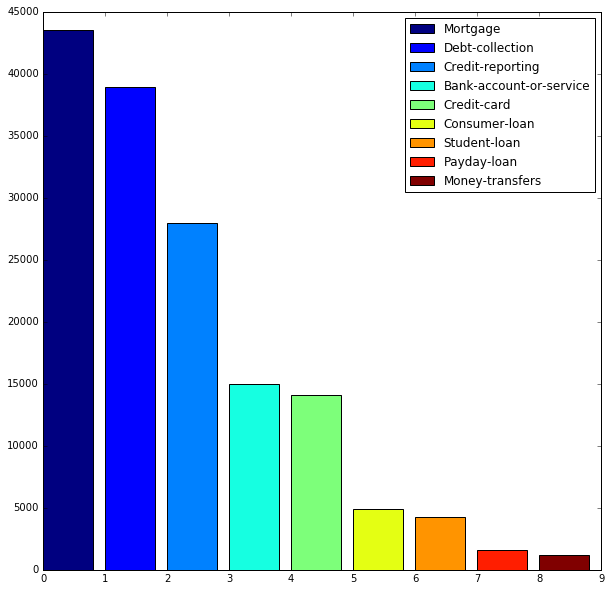

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
data=np.array([
        ["Mortgage", 43533],
        ["Debt-collection", 38938],
        ["Credit-reporting", 27996],
        ["Bank-account-or-service", 14945],
        ["Credit-card", 14058],
        ["Consumer-loan", 4921],
        ["Student-loan", 4280],
        ["Payday-loan", 1579],
        ["Money-transfers", 1183],
    ])
plt.figure(figsize=(10,10))
cm=plt.get_cmap('jet')
axes=plt.bar(range(0,data.shape[0]), data[:,1],
             color=cm(np.linspace(0,1,data.shape[0])))
plt.legend(axes, data[:,0])
plt.show()

---
## HW 3.2
### Analyze the performance of your Mappers, Combiners and Reducers using Counters

For this brief study the Input file will be one record (the next line only):
```
foo foo quux labs foo bar quux
```

### HW 3.2a
Perform a word count analysis of this single record dataset using a Mapper and Reducer based WordCount (i.e., no combiners are used here) using user defined Counters to count up how many time the mapper and reducer are called. What is the value of your user defined Mapper Counter, and Reducer Counter after completing this word count job. The answer  should be 1 and 4 respectively. Please explain.

In [7]:
%%writefile hw3.2a-input.txt
foo foo quux labs foo bar quux

Overwriting hw3.2a-input.txt


In [8]:
%%writefile hw3.2a-mapper.py
#!/opt/anaconda3/bin/python
from collections import Counter
import sys
from inc_counter import increment_counter

for line in sys.stdin:
    increment_counter('invocations', 'mapper')
    for key, val in Counter(line.split()).items():
        print('{}\t{}'.format(key,val))

Overwriting hw3.2a-mapper.py


In [9]:
%%writefile hw3.2a-reducer.py
#!/opt/anaconda3/bin/python
from collections import Counter
import sys
from inc_counter import increment_counter

prev=None
tot=0
for line in sys.stdin:
    increment_counter('invocations', 'reducer')
    fields=line.split()
    word=fields[0]
    if prev and word != prev:
        print('{}\t{}'.format(prev,tot))
        tot=0
    tot+=sum(int(count) for count in fields[1:])
    prev=word
print('{}\t{}'.format(prev,tot))

Overwriting hw3.2a-reducer.py


In [10]:
%%bash
chmod +x hw3.2a*py
rm -rf hw3.2a-output
# sanity check
(./hw3.2a-mapper.py < hw3.2a-input.txt | sort -k1 | ./hw3.2a-reducer.py) 2>&1 | sort -u
# real run:
export HADOOP_HOME=/opt/hadoop-2.7.1
export PATH=$PATH:$HADOOP_HOME/bin
hadoop jar ${HADOOP_HOME}/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
  -D mapreduce.job.maps=1 \
  -D mapreduce.job.reduces=4 \
  -mapper $PWD/hw3.2a-mapper.py \
  -reducer $PWD/hw3.2a-reducer.py \
  -input file://$PWD/hw3.2a-input.txt \
  -output file://$PWD/hw3.2a-output
echo $?

bar	1
foo	3
labs	1
quux	2
reporter:counter:invocations,mapper,1
reporter:counter:invocations,reducer,1
packageJobJar: [/tmp/hadoop-unjar1245787202396111742/] [] /tmp/streamjob8898031820546262053.jar tmpDir=null
0


16/01/31 21:48:25 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/31 21:48:25 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/31 21:48:26 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/31 21:48:26 INFO mapreduce.JobSubmitter: number of splits:1
16/01/31 21:48:26 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453955019658_0089
16/01/31 21:48:26 INFO impl.YarnClientImpl: Submitted application application_1453955019658_0089
16/01/31 21:48:26 INFO mapreduce.Job: The url to track the job: http://nkrishna-linux:8088/proxy/application_1453955019658_0089/
16/01/31 21:48:26 INFO mapreduce.Job: Running job: job_1453955019658_0089
16/01/31 21:48:31 INFO mapreduce.Job: Job job_1453955019658_0089 running in uber mode : false
16/01/31 21:48:31 INFO mapreduce.Job:  map 0% reduce 0%
16/01/31 21:48:36 INFO mapreduce.Job:  map 100% reduce 0%
16/01/31 21:48:42 INFO mapreduce.Job:  map 100% reduce 25%
16/01/31 21:48:43 

**Answer**:  
The question is ill posed. By default there are 2 map tasks and 1 one reduce task created, so "calls" in the sense of script invocations are 2 and 1, respectively.  If number of input rows is what is intended, these are 1 (row) and 7 (words) rather than 1 and 4, since the mapper rows are not combined outside the reducer.  If the outputs of each step are considered, these are 7 and 4, respectively.  
To force alignment, I used configured my job to use 1 mapper and 4 reducers, and to count records, and combined counts in the mapper.  There are several other ways to produce this output, all with similarly low pedagogical value.

### HW 3.2b
Please use mulitple mappers and reducers for these jobs (at least 2 mappers and 2 reducers).
Perform a word count analysis of the Issue column of the Consumer Complaints  Dataset using a Mapper and Reducer based WordCount (i.e., no combiners used anywhere)  using user defined Counters to count up how many time the mapper and reducer are called. What is the value of your user defined Mapper Counter, and Reducer Counter after completing your word count job. 

In [ ]:
%%writefile hw3.2b-mapper.py
#!/opt/anaconda3/bin/python
from collections import Counter
from csv import DictReader
import sys
from inc_counter import increment_counter

for row in DictReader(sys.stdin):
    increment_counter('invocations', 'mapper')
    if 'Issue' in row:
        for key,val in Counter(row['Issue'].split()).items():
            print('{}\t{}'.format(key, val))

In [ ]:
%%writefile hw3.2b-reducer.py
#!/opt/anaconda3/bin/python
from collections import Counter
import sys
from inc_counter import increment_counter

prev=None
tot=0
for line in sys.stdin:
    increment_counter('invocations', 'reducer')
    fields=line.split()
    word=fields[0]
    if prev and word != prev:
        print('{}\t{}'.format(prev,tot))
        tot=0
    tot+=sum(int(count) for count in fields[1:])
    prev=word
print('{}\t{}'.format(prev,tot))

In [ ]:
%%bash
chmod +x hw3.2b-*.py
rm -rf hw3.2b-output
export HADOOP_HOME=/opt/hadoop-2.7.1
export PATH=$PATH:$HADOOP_HOME/bin
# sanity check
./hw3.2b-mapper.py < Consumer_Complaints.csv | sort -k1 | ./hw3.2b-reducer.py >/dev/null
# real run:
hadoop jar ${HADOOP_HOME}/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
  -D mapreduce.job.maps=2 \
  -D mapreduce.job.reduces=2 \
  -mapper $PWD/hw3.2b-mapper.py \
  -reducer $PWD/hw3.2b-reducer.py \
  -input file://$PWD/Consumer_Complaints.csv \
  -output file://$PWD/hw3.2b-output
echo $?

**Answer**:  
Using the same methodology as in 3.2.a shows the mapper processed 312911 records, and the reducer 632320.

### HW 3.2c
Perform a word count analysis of the Issue column of the Consumer Complaints  Dataset using a Mapper, Reducer, and standalone combiner (i.e., not an in-memory combiner) based WordCount using user defined Counters to count up how many time the mapper, combiner, reducer are called. What is the value of your user defined Mapper Counter, and Reducer Counter after completing your word count job.

In [ ]:
%%writefile hw3.2c-combiner.py
#!/opt/anaconda3/bin/python
from collections import Counter
import sys
from inc_counter import increment_counter

prev=None
tot=0
for line in sys.stdin:
    increment_counter('invocations', 'combiner')
    fields=line.split()
    word=fields[0]
    if prev and word != prev:
        print('{}\t{}'.format(prev,tot))
        tot=0
    tot+=sum(int(count) for count in fields[1:])
    prev=word
print('{}\t{}'.format(prev,tot))

In [ ]:
%%bash
chmod +x hw3.2*.py
./hw3.2a-mapper.py < hw3.2a-input.txt | sort -k1 | ./hw3.2a-reducer.py 2>&1 | sort -u
rm -rf hw3.2c-output
export HADOOP_HOME=/opt/hadoop-2.7.1
export PATH=$PATH:$HADOOP_HOME/bin
hadoop jar ${HADOOP_HOME}/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
  -D mapreduce.job.maps=2 \
  -D mapreduce.job.reduces=2 \
  -mapper $PWD/hw3.2b-mapper.py \
  -reducer $PWD/hw3.2b-reducer.py \
  -combiner $PWD/hw3.2c-combiner.py \
  -input file://$PWD/Consumer_Complaints.csv \
  -output file://$PWD/hw3.2c-output
echo $?

**Answer**:  
We see that the mapper count is the same, and the combiner count is 632320 (same as reducer in 3.2b).  Since the combiner like-keyed mapper outputs are combined, however, there are only 182 key/vals passed to the reducer.

### HW 3.2d
Using a single reducer: What are the top 50 most frequent terms in your word count analysis? Present the top 50 terms and their frequency and their relative frequency. Present the top 50 terms and their frequency and their relative frequency. If there are ties please sort the tokens in alphanumeric/string order. Present bottom 10 tokens (least frequent items). 

In [42]:
%%writefile hw3.2d-mapper.py
#!/opt/anaconda3/bin/python
from collections import Counter
from csv import DictReader
import re
import sys
nw=re.compile(r'\W+')
tot=0
for row in DictReader(sys.stdin):
    if 'Issue' in row:
        for key,val in Counter(nw.split(row['Issue'])).items():
            tot += val
            print('{}\t{}'.format(key, val))
print('{}\t{}'.format('*tot', tot))
exit(0)

Overwriting hw3.2d-mapper.py


In [34]:
%%writefile hw3.2d-reducer.py
#!/opt/anaconda3/bin/python
import sys

prev=None
num_terms=0
tot=0
for line in sys.stdin:
    fields=line.split()
    word=fields[0]
    if prev and word != prev:
        if prev=='*tot':
            num_terms=tot
        else:
            print('{}\t{}\t{}'.format(tot,prev,1.0*tot/num_terms))
        tot=0
    tot+=sum(int(count) for count in fields[1:])
    prev=word
print('{}\t{}\t{}'.format(tot,prev,1.0*tot/num_terms))
exit(0)

Overwriting hw3.2d-reducer.py


In [37]:
%%writefile hw3.2d-combiner.py
#!/opt/anaconda3/bin/python
import sys

prev=None
tot=0
for line in sys.stdin:
    fields=line.split()
    word=fields[0]
    if prev and word != prev:
        print('{}\t{}'.format(prev,tot))
        tot=0
    tot+=sum(int(count) for count in fields[1:])
    prev=word
print('{}\t{}'.format(prev,tot))
exit(0)

Writing hw3.2d-combiner.py


In [48]:
%%bash
chmod +x hw3.2d*py
#./hw3.2d-mapper.py < Consumer_Complaints.csv | LANG=POSIX sort -k1 -rnk2 | ./hw3.2d-combiner.py | LANG=POSIX sort -k1 -rnk2  | head

rm -rf hw3.2d-output
export HADOOP_HOME=/opt/hadoop-2.7.1
export PATH=$PATH:$HADOOP_HOME/bin
hadoop jar ${HADOOP_HOME}/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2nr -k1" \
  -D stream.num.map.output.key.fields=2 \
  -D mapreduce.partition.keypartitioner.options=-k1,1 \
  -D mapreduce.job.maps=4 \
  -D mapreduce.job.reduces=1 \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -mapper $PWD/hw3.2d-mapper.py \
  -combiner $PWD/hw3.2d-combiner.py \
  -reducer cat \
  -input file://$PWD/Consumer_Complaints.csv \
  -output file://$PWD/hw3.2d-output
echo $?

packageJobJar: [/tmp/hadoop-unjar5509660164972964732/] [] /tmp/streamjob2378645748922472149.jar tmpDir=null
0


16/01/31 22:40:32 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/31 22:40:32 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/31 22:40:32 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/31 22:40:33 INFO mapreduce.JobSubmitter: number of splits:4
16/01/31 22:40:33 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453955019658_0096
16/01/31 22:40:33 INFO impl.YarnClientImpl: Submitted application application_1453955019658_0096
16/01/31 22:40:33 INFO mapreduce.Job: The url to track the job: http://nkrishna-linux:8088/proxy/application_1453955019658_0096/
16/01/31 22:40:33 INFO mapreduce.Job: Running job: job_1453955019658_0096
16/01/31 22:40:38 INFO mapreduce.Job: Job job_1453955019658_0096 running in uber mode : false
16/01/31 22:40:38 INFO mapreduce.Job:  map 0% reduce 0%
16/01/31 22:40:47 INFO mapreduce.Job:  map 25% reduce 0%
16/01/31 22:40:50 INFO mapreduce.Job:  map 75% reduce 0%
16/01/31 22:40:52 INF

---
## HW3.2.1 OPTIONAL 
Using 2 reducers: What are the top 50 most frequent terms in your word count analysis? Present the top 50 terms and their frequency and their relative frequency. Present the top 50 terms and their frequency and their relative frequency. If there are ties please sort the tokens in alphanumeric/string order. Present bottom 10 tokens (least frequent items). 

--
## HW3.3.
### Shopping Cart Analysis
*Product Recommendations*: The action or practice of selling additional products or services 
to existing customers is called cross-selling. Giving product recommendation is 
one of the examples of cross-selling that are frequently used by online retailers. 
One simple method to give product recommendations is to recommend products that are frequently
browsed together by the customers.

For this homework use the online browsing behavior dataset located at: 

       https://www.dropbox.com/s/zlfyiwa70poqg74/ProductPurchaseData.txt?dl=0

Each line in this dataset represents a browsing session of a customer.  
On each line, each string of 8 characters represents the id of an item browsed during that session.  
The items are separated by spaces.

Here are the first few lines of the ProductPurchaseData:
```
FRO11987 ELE17451 ELE89019 SNA90258 GRO99222 
GRO99222 GRO12298 FRO12685 ELE91550 SNA11465 ELE26917 ELE52966 FRO90334 SNA30755 ELE17451 FRO84225 SNA80192 
ELE17451 GRO73461 DAI22896 SNA99873 FRO86643 
ELE17451 ELE37798 FRO86643 GRO56989 ELE23393 SNA11465 
ELE17451 SNA69641 FRO86643 FRO78087 SNA11465 GRO39357 ELE28573 ELE11375 DAI54444 
```

Do some exploratory data analysis of this dataset. 

How many unique items are available from this supplier?

Using a single reducer: Report your findings such as number of unique products; largest basket; report the top 50 most frequently purchased items,  their frequency,  and their relative frequency (break ties by sorting the products alphabetical order) etc. using Hadoop Map-Reduce. 

## HW3.3.1 OPTIONAL 
Using 2 reducers:  Report your findings such as number of unique products; largest basket; report the top 50 most frequently purchased items,  their frequency,  and their relative frequency (break ties by sorting the products alphabetical order) etc. using Hadoop Map-Reduce. 

---
## HW3.4. (Computationally prohibitive but then again Hadoop can handle this) Pairs

Suppose we want to recommend new products to the customer based on the products they
have already browsed on the online website. Write a map-reduce program 
to find products which are frequently browsed together. Fix the support count (cooccurence count) to s = 100  
(i.e. product pairs need to occur together at least 100 times to be considered frequent) 
and find pairs of items (sometimes referred to itemsets of size 2 in association rule mining) that have a support count of 100 or more.

List the top 50 product pairs with corresponding support count (aka frequency), and relative frequency or support (number of records where they coccur, the number of records where they coccur/the number of baskets in the dataset)  in decreasing order of support  for frequent (100>count) itemsets of size 2. 

Use the Pairs pattern (lecture 3)  to  extract these frequent itemsets of size 2. Free free to use combiners if they bring value. Instrument your code with counters for count the number of times your mapper, combiner and reducers are called.  

Please output records of the following form for the top 50 pairs (itemsets of size 2): 
```
item1, item2, support count, support
```


Fix the ordering of the pairs lexicographically (left to right), 
and break ties in support (between pairs, if any exist) 
by taking the first ones in lexicographically increasing order. 

Report  the compute time for the Pairs job. Describe the computational setup used (E.g., single computer; dual core; linux, number of mappers, number of reducers)

Instrument your mapper, combiner, and reducer to count how many times each is called using Counters and report these counts.

---
## HW3.5: Stripes
Repeat 3.4 using the stripes design pattern for finding cooccuring pairs.

Report  the compute times for stripes job versus the Pairs job. Describe the computational setup used (E.g., single computer; dual core; linux, number of mappers, number of reducers)

Instrument your mapper, combiner, and reducer to count how many times each is called using Counters and report these counts. Discuss the differences in these counts between the Pairs and Stripes jobs

---
# OPTIONAL: All HW below this are optional 

**NOTE**: as of 1/28/2016 the instructions needs to be completed (Talk to Jimi)

## Preliminary information

Much of this homework beyond this point will focus on the Apriori algorithm for frequent itemset  mining and the additional step for extracting association rules from these frequent itemsets.
Please acquaint yourself with the background information (below)
before approaching the remaining  assignments.

## Apriori background information

Some background material for the  Apriori algorithm is located at:

 * Slides in Live Session #3
 * https://en.wikipedia.org/wiki/Apriori_algorithm
 * https://www.dropbox.com/s/k2zm4otych279z2/Apriori-good-slides.pdf?dl=0
 * http://snap.stanford.edu/class/cs246-2014/slides/02-assocrules.pdf

*Association Rules* are frequently used for *Market Basket Analysis* (MBA) by retailers to
understand the purchase behavior of their customers. This information can be then used for
many different purposes such as cross-selling and up-selling of products, sales promotions,
loyalty programs, store design, discount plans and many others.

*Evaluation of item sets*: Once you have found the frequent itemsets of a dataset, you need
to choose a subset of them as your recommendations. Commonly used metrics for measuring
significance and interest for selecting rules for recommendations are: confidence; lift; and conviction.

---
## HW3.6
What is the Apriori algorithm? Describe an example use in your domain of expertise and what kind of . Define confidence and lift.

**NOTE**: For the remaining homework use the online browsing behavior dataset located at (same dataset as used above): 

* https://www.dropbox.com/s/zlfyiwa70poqg74/ProductPurchaseData.txt?dl=0

Each line in this dataset represents a browsing session of a customer.  
On each line, each string of 8 characters represents the id of an item browsed during that session.  
The items are separated by spaces.

Here are the first few lines of the ProductPurchaseData 
```
FRO11987 ELE17451 ELE89019 SNA90258 GRO99222 
GRO99222 GRO12298 FRO12685 ELE91550 SNA11465 ELE26917 ELE52966 FRO90334 SNA30755 ELE17451 FRO84225 SNA80192 
ELE17451 GRO73461 DAI22896 SNA99873 FRO86643 
ELE17451 ELE37798 FRO86643 GRO56989 ELE23393 SNA11465 
ELE17451 SNA69641 FRO86643 FRO78087 SNA11465 GRO39357 ELE28573 ELE11375 DAI54444 
```

## HW3.7. Shopping Cart Analysis
*Product Recommendations*: The action or practice of selling additional products or services 
to existing customers is called cross-selling. Giving product recommendation is 
one of the examples of cross-selling that are frequently used by online retailers. 
One simple method to give product recommendations is to recommend products that are frequently
browsed together by the customers.

Suppose we want to recommend new products to the customer based on the products they
have already browsed on the online website. Write a program using the A-priori algorithm
to find products which are frequently browsed together. Fix the support to s = 100 
(i.e. product sets need to occur together at least 100 times to be considered frequent) 
and find itemsets of size 2 and 3.

Then extract association rules from these frequent items. 

A rule is of the form: 

    (item1, item5) ⇒ item2.

List the top 10 discovered rules in descreasing order of confidence in the following format
 
    (item1, item5) ⇒ item2, supportCount ,support, confidence

## HW3.8

Benchmark your results using the pyFIM implementation of the Apriori algorithm
(Apriori - Association Rule Induction / Frequent Item Set Mining implemented by Christian Borgelt).  
You can download pyFIM from here: 

* http://www.borgelt.net/pyfim.html

Comment on the results from both implementations (your Hadoop MapReduce of apriori versus pyFIM) in terms of results and execution times.

## HW3.8 (Conceptual Exercise)

Suppose that you wished to perform the Apriori algorithm once again,
though this time now with the goal of listing the top 5 rules with corresponding confidence scores  in decreasing order of confidence score for itemsets of size 3 using Hadoop MapReduce.

A rule is now of the form: 

    (item1, item2) ⇒ item3 

Recall that the Apriori algorithm is iterative for increasing itemset size,
working off of the frequent itemsets of the previous size to explore 
ONLY the NECESSARY subset of a large combinatorial space. 
Describe how you might design a framework to perform this exercise.

In particular, focus on the following:

* map-reduce steps required
* enumeration of item sets and filtering for frequent candidates
